![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/NotebookVM/tutorials/tutorial-quickstart-train-model.png)

# Training first model

## Connect workspace and create experiment

Import the `Workspace` class, and load your subscription information from the file `config.json` using the function `from_config().` This looks for the JSON file in the current directory by default, but you can also specify a path parameter to point to the file using `from_config(path="your/file/path")`. If you are running this notebook in a cloud notebook server in your workspace, the file is automatically in the root directory.


In [31]:
from azureml.core import Workspace
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from azureml.core import Experiment
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.stats as st
import sklearn.linear_model as linear_model
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [4]:
ws = Workspace.from_config()

Now, we create an experiment in the workspace. An experiment represents a collection of trials (individual model runs).

In [5]:
experiment = Experiment(workspace=ws, name="azureml-experiment")

## Load data and prepare for training

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

Loading the file which contains the data for model training

In [7]:
train_file_path = 'train.csv'
train_data = pd.read_csv(train_file_path)
print(train_data.describe())

                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456.098091  ..

In [24]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# EDA

#### 1. Distribution of missing values

In [26]:
train_data.shape

(1460, 81)

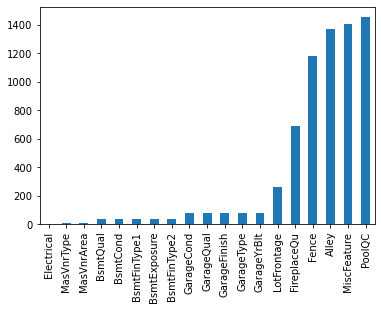

In [25]:
missing = train_data.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

19 attributes have missing values, 5 over 50% of all data.

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar 

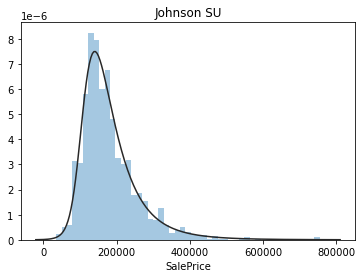

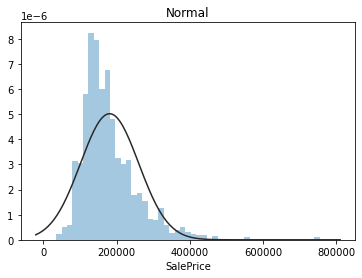

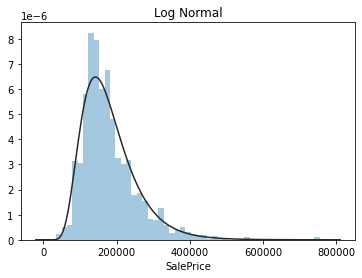

In [32]:

y = train_data['SalePrice']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)

It is apparent that SalePrice doesn't follow normal distribution, so before performing regression it has to be transformed. While log transformation does pretty good job, best fit is unbounded Johnson distribution.

In [34]:
quantitative = [f for f in train_data.columns if train_data.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in train_data.columns if train_data.dtypes[f] == 'object']

#### Distribution of sales price for different classes of categorical varibales
Neighborhood has big impact on house prices

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


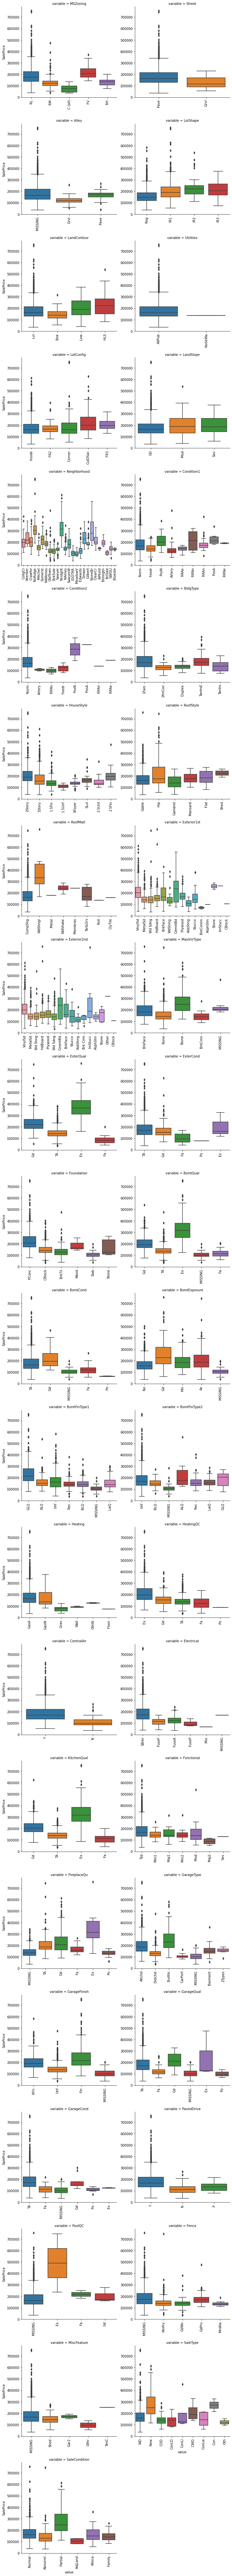

In [38]:
for c in qualitative:
    train_data[c] = train_data[c].astype('category')
    if train_data[c].isnull().any():
        train_data[c] = train_data[c].cat.add_categories(['MISSING'])
        train_data[c] = train_data[c].fillna('MISSING')

def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
f = pd.melt(train_data, id_vars=['SalePrice'], value_vars=qualitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "SalePrice")

Correlations

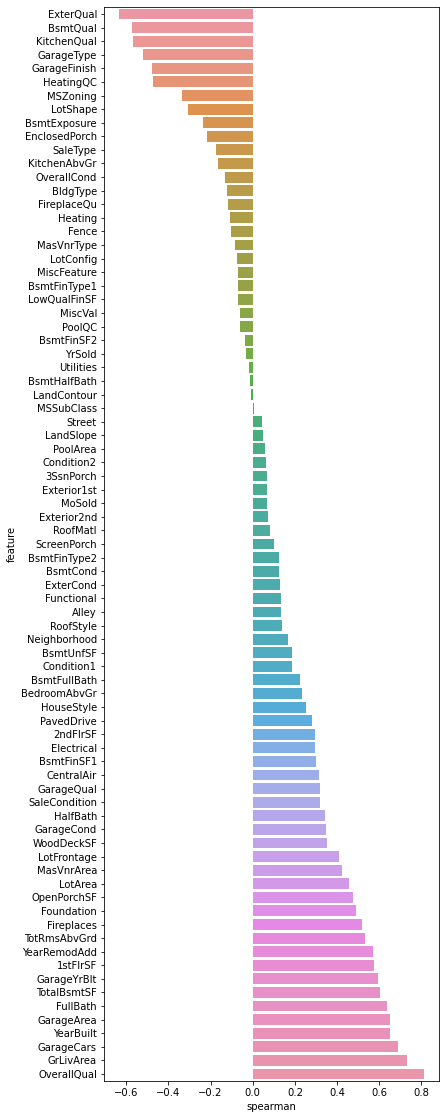

In [39]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = quantitative + qualitative
spearman(train_data, features)

# Model Training

Defining the independent and dependent variables for model training and validation

In [8]:
y = train_data.SalePrice
house_price_predictors = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 
                        'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd','OverallQual','OverallCond','MSSubClass','LowQualFinSF','GrLivArea']
X = train_data[house_price_predictors]

In [9]:

# Define model 
iowa_model = DecisionTreeRegressor()
forest_model = RandomForestRegressor()

# Fitting the model
iowa_model.fit(X,y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

#### Now as the model is ready we will make some predictions of House Prices. We shall select Head for top 5 houses

In [10]:
print("Lets predict prices of some houses!")
print(X.head())
print("The predictions are :")
print(iowa_model.predict(X.head()))

Lets predict prices of some houses!
   LotArea  YearBuilt  1stFlrSF  2ndFlrSF  FullBath  BedroomAbvGr  \
0     8450       2003       856       854         2             3   
1     9600       1976      1262         0         2             3   
2    11250       2001       920       866         2             3   
3     9550       1915       961       756         1             3   
4    14260       2000      1145      1053         2             4   

   TotRmsAbvGrd  OverallQual  OverallCond  MSSubClass  LowQualFinSF  GrLivArea  
0             8            7            5          60             0       1710  
1             6            6            8          20             0       1262  
2             6            7            5          60             0       1786  
3             7            7            5          70             0       1717  
4             9            8            5          60             0       2198  
The predictions are :
[208500. 181500. 223500. 140000. 250000.]

#### Important aspect is Model Validation , checking how well is the model performing
MAE (Mean Absolute Error) Mertic: Error = (Actual - Prediction), Absolute = Positive Value, Mean = Average of the errors

In [11]:
predicted_house_prices = iowa_model.predict(X)
mean_absolute_error(y,predicted_house_prices)

23.1420091324201

In [13]:
# Validation Data : Using split function to split on based of Train and Test data
train_X,val_X,train_y,val_y = train_test_split(X,y, random_state = 0)

# Define Model 
iowa_house_model = DecisionTreeRegressor()

# Fit the model
iowa_house_model.fit(train_X,train_y)

# get the predicted prices of house, here we predict on next set other thean training set
val_predictions = iowa_house_model.predict(val_X)
mean_absolute_error(val_y,val_predictions)

27570.197260273973

#### Concepts of Overfitting, Underfitting and Model optimization
##### Overfitting : In case Tree based model, when the depth of tree is too much high, the leafs would be high and thus model matches trainign data accurately.This catches patterns which wont be of specific use in general. Thus performs bad on testing data
##### UnderFitting : Tree depth is shallow and we spilt data in very few patterns example 2-4 leaves. Thus we would fail in capturing important patterns.
##### Balance has to be in capturing optimal middle ware between which performs well.


In [16]:
def get_mae(max_leaf_nodes, predictors_train, predictors_val, targ_train, targ_val):
    model = DecisionTreeRegressor(max_leaf_nodes = max_leaf_nodes, random_state=0)
    model.fit(predictors_train, targ_train)
    pred_vals = model.predict(predictors_val)
    mae = mean_absolute_error(targ_val,pred_vals)
    return mae

In [17]:
# Now lets try different max_leaf values and identify the optimal leaf value at which mea is lowest
# Low MEA is directly proportional to model perfoming better

for max_leaf_nodes in [5, 50, 500, 5000]:
    my_mae = get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y)
    print("Max leaf nodes: %d  \t\t Mean Absolute Error:  %d" %(max_leaf_nodes, my_mae))
    
# Here we observe at max_leaf_nodes of 50, model performs better.

Max leaf nodes: 5  		 Mean Absolute Error:  32550
Max leaf nodes: 50  		 Mean Absolute Error:  23773
Max leaf nodes: 500  		 Mean Absolute Error:  26139
Max leaf nodes: 5000  		 Mean Absolute Error:  26483


#### Lets dive into some other model to look into the performance
 Decision tree leaves you with a complex decsion of max_leaves to perform optimally
 Too many leaves tend to cause overfitting and thus perform bad on testing data
 Few leaves cause underfitting and thus loose out crucial patterns
 RandomForest is the model which uses may trees,  and it makes a prediction by averaging the predictions of each component tree. This may be better than a single deciosn tree
 Lets check out the results


In [20]:
forest_model  = RandomForestRegressor()
forest_model.fit(X,y)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

#### Model logging and experimentation

In [21]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import joblib
import math

leaf = [5, 50, 500, 5000]

for max_leaf_nodes in leaf:
    run = experiment.start_logging()
    run.log("leaf_value", max_leaf_nodes)
    
    model = RandomForestRegressor(max_leaf_nodes = max_leaf_nodes, random_state=0)
    model.fit(X=train_X, y=train_y)
    y_pred = model.predict(X=val_X)
    mae = mean_absolute_error(val_y,y_pred)
    run.log("mae", mae)
    
    model_name = "model_leaf_" + str(max_leaf_nodes) + ".pkl"
    filename = "outputs/" + model_name
    
    joblib.dump(value=model, filename=filename)
    run.upload_file(name=model_name, path_or_stream=filename)
    run.complete()

In [22]:
experiment

Name,Workspace,Report Page,Docs Page
azureml-experiment,azureml-test,Link to Azure Machine Learning studio,Link to Documentation
